# Single cell transcriptomic analyses of human pancreatic islets

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight

# Magic incantation to help matplotlib work with our jupyter notebook.
%matplotlib inline 

import warnings;
warnings.filterwarnings('ignore');

# Random seed for consistent results.
seed = 42

In [2]:
# Open the labels file.
label = pd.read_csv('GSE86469_Class_Label.txt', delimiter='!', engine='c', 
                     lineterminator='\t').rename(columns={'Unnamed: 0':'sample_id'})
label = label.replace('\r\n','', regex=True)
# Drop the column with the missing values.
label = label.dropna(axis=1, how='any')
# Create a new dataframe with the labels.
characteristic = pd.DataFrame(label['sample_id'].loc[638 :]).rename(columns={'sample_id':'sample_label'})
# Reset the index in place.
characteristic = characteristic.reset_index(drop=True)
characteristic = characteristic.apply(lambda x: x.replace({'disease: Non-Diabetic': 0,
                                                           'disease: Type 2 Diabetic':1}, regex=True))
label = label.drop(label.index[638:], axis=0)
label['label']= characteristic['sample_label']

# View out of the 638 single cells how many can trigger a response that can cause diabetes type 2.
label['label'].value_counts()
# The dataset is imbalanced with the non-diabetic values to be dominating.

0    380
1    258
Name: label, dtype: int64

In [3]:
# Set the index to be the cell names.
label.index = label['sample_id']
label.index.names = ['cell_id']
cell_id = label.drop(['sample_id'], axis=1)

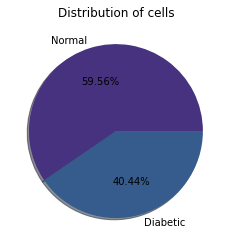

In [4]:
# Distribution plot.
plt.figure(figsize=plt.figaspect(1))
plt.pie(cell_id['label'].value_counts(),
       autopct='%.2f%%',
       labels=['Normal', 'Diabetic'],
       colors=sns.color_palette('viridis'),
       shadow=True)
plt.title('Distribution of cells')
plt.show()

In [5]:
# Open the same file as a DataFrame.
genes = pd.read_csv('GSE86469_Data.csv', sep=',')
# Transpose the DataFrame so that rows=cells & columns=genes.
cells = genes.transpose()
cells = cells.drop(labels='Unnamed: 0', axis=0)

In [6]:
# Retain a copy of the original dataset for testing.
cell_original = np.array(cells)

The data is a table of counts, integers representing how many reads were observed for each gene in each cell type.

### Quality Control

Single-cell RNA-sequencing (scRNA-seq) techniques measure gene expression at the individual cell level. This requires amplification of truly minute quantities of mRNA, resulting in a phenomenon called “dropout” in which an expressed transcript is not detected and hence assigned a zero expression value. As a result, we define two types of zeros in the observed matrix: biological zeros (genes that were not expressed at the time of sequencing) and technical zeros (genes that were expressed at the time of sequencing but not measured).

In [7]:
# # Replace close to zero values with 0.
# for x in np.arange(0, 0.5, 0.01):
#     cells.replace(x, 0, inplace=True)

This ensures that with high probability all of the entries which correspond to biological zeros are set to zero. 

In [8]:
# Create an annData object out of the dataFrame to use Scanpy.
adata = sc.AnnData(X = cells, obs = cell_id)

At the most basic level, an AnnData object adata stores a data matrix adata.X, annotation of observations adata.obs and variables adata.var as pd.DataFrame.

In [9]:
qc = sc.pp.calculate_qc_metrics(adata)
# This returns a tuple of (cell_qc_dataframe, gene_qc_dataframe).
cell_qc_dataframe = qc[0] # Cell quality control dataframe.
gene_qc_dataframe = qc[1] # Genes quality control dataframe.

cell_qc_dataframe
* 'n_genes_by_counts' : The number of genes with at least 1 count in a cell. Calculated for all cells.
* 'log1p_n_genes_by_counts'  (log(1+x)) where x is count of unique genes in a cell.
* 'total_counts' : Total number of counts for a cell.
* 'log1p_total_counts' : (log(1+x)) where x is total count of genes in a cell.
* 'pct_counts_in_top_50_genes' : Cumulative percentage of counts for 50 most expressed genes in a cell.

gene_qc_dataframe
* 'n_cells_by_counts' : Number of cells this expression is measured in.
* 'mean_counts' : Mean expression over all cells.
* 'pct_dropout_by_counts' : Percentage of cells this feature does not appear in.
* 'total_counts' : Sum of counts for a gene.

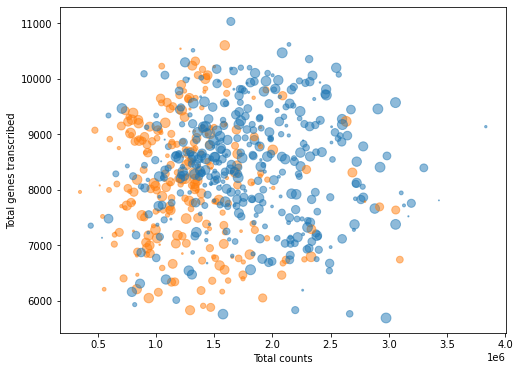

In [10]:
# Visualization of the data(cells).
rng = np.random.RandomState(seed)

sizes = 100 * rng.rand(len(cells))
plt.figure(figsize=(8, 6))
plt.scatter(cell_qc_dataframe['total_counts'], cell_qc_dataframe['n_genes_by_counts'], 
            c=[sns.color_palette()[x] for x in label.label.map({0:0, 1:1})], s=sizes, alpha=0.5, cmap='viridis')
plt.xlabel('Total counts')
plt.ylabel('Total genes transcribed')
plt.show()

In [11]:
upper_lim = np.quantile(cell_qc_dataframe.n_genes_by_counts, .98)
lower_lim = np.quantile(cell_qc_dataframe.n_genes_by_counts, .02)
print(f'{lower_lim} to {upper_lim}')

6160.7 to 10200.26


In [12]:
sum(cell_qc_dataframe['total_counts'] < 50000) # View the cells with fewer than 50.000 reads.

0

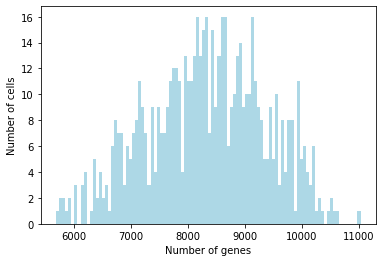

In [13]:
n, bins, patches = plt.hist(cell_qc_dataframe['n_genes_by_counts'], 100, facecolor='lightblue')
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.show()
# From the plot we conclude that most cells have between ~6,000-10,000 detected genes.

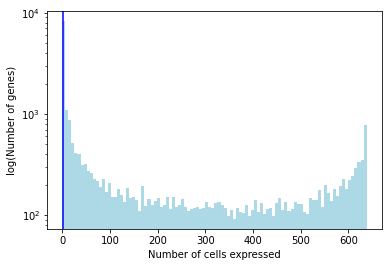

In [14]:
n, bins, patches = plt.hist(gene_qc_dataframe['n_cells_by_counts'], 100, facecolor='lightblue')
plt.xlabel('Number of cells expressed')
plt.ylabel('log(Number of genes)') # For visual clarity.
plt.axvline(2, color='blue')
plt.yscale('log') 
plt.show()

In [15]:
print('There are', sum(gene_qc_dataframe['n_cells_by_counts'] < 2), 'genes which are having n_cells_by_counts < 2 and',
      sum(gene_qc_dataframe['total_counts'] < 10), 'genes which are having sum_counts < 10')

There are 5807 genes which are having n_cells_by_counts < 2 and 6009 genes which are having sum_counts < 10


In [16]:
print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells = 2)
sc.pp.filter_genes(adata, min_counts = 10)
print('Finished with: \n', adata)
# 6.490 genes we're dropped off the dataset.

Started with: 
 AnnData object with n_obs × n_vars = 638 × 26616
    obs: 'label'
Finished with: 
 AnnData object with n_obs × n_vars = 638 × 20154
    obs: 'label'
    var: 'n_cells', 'n_counts'


### High variable genes

In [17]:
adata_hv = adata.copy()

In [18]:
# Logaritmize(change to log counts).
sc.pp.log1p(adata_hv)
# Cannot specify integer `bins` when input data contains infinity.

Highly variable genes: 2000


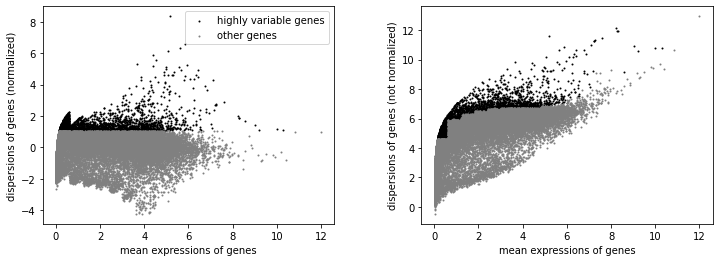

In [19]:
# Compute variable genes.(Expects logarithmized data)
sc.pp.highly_variable_genes(adata_hv, n_top_genes=2000)
print("Highly variable genes: %d"%sum(adata_hv.var.highly_variable))

# Plot variable genes.
sc.pl.highly_variable_genes(adata_hv)

# Subset for variable genes in the dataset.
adata_hv = adata_hv[:, adata_hv.var['highly_variable']]

In the above plots is shown the variance of the genes on the y-axis and the mean expression. A variance stabilizing transformation is being performed in order for the variance of each gene to not be so depended upon the mean expression.

In [20]:
sc.pp.scale(adata_hv, zero_center=True) 
sc.pp.pca(adata_hv, n_comps=50) 
# PCA: By default uses the highly variable genes if they have been determined beforehand.

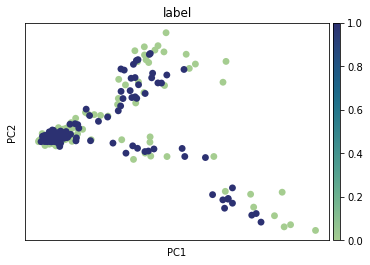

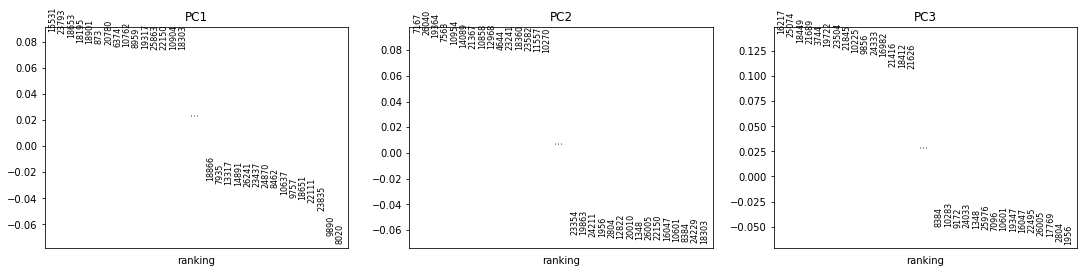

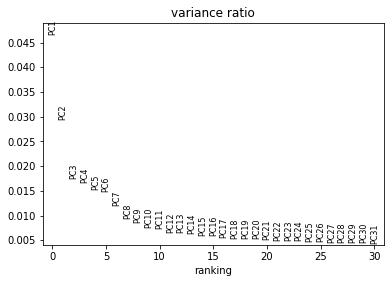

In [21]:
sc.pl.pca_overview(adata_hv, color='label', color_map='crest')

adata_hv will be kept for clustering.

### Normalization

Normalized expression units are necessary to remove technical biases in sequenced data such as depth of sequencing and gene length, and make gene expressions directly comparable within and across samples. This is because more sequencing depth produces more read count for a gene expressed at the same level and differences in gene length generate unequal reads count for genes expressed at the same level (longer the gene more the read count).
Moreover, normalized expression units help to remove batch effects.

In [22]:
# Keep the data with the highly variable genes and create a copy.
adata_copy = adata.copy()
adata_copy.raw = adata_copy  # Store a copy of the raw values before normalizing.

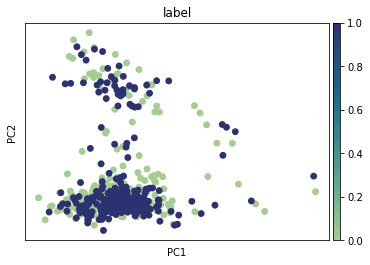

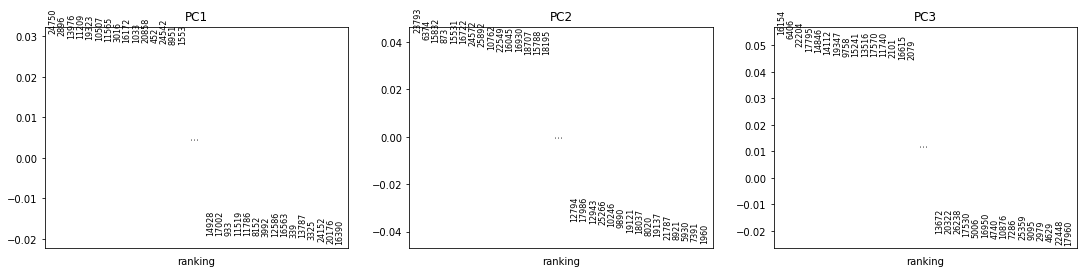

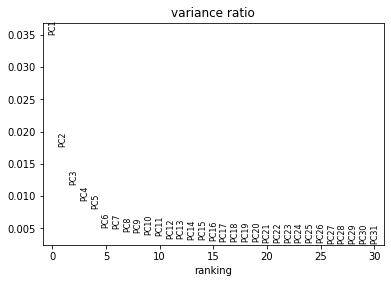

In [23]:
sc.pp.log1p(adata_copy)  # Returns or updates data, depending on copy. X = log(X + 1) .
sc.pp.normalize_total(adata_copy, exclude_highly_expressed=True)
# Very highly expressed genes are excluded from the computation, as these can strongly 
#                             influence the resulting normalized values for all other genes. 
sc.pp.scale(adata_copy, zero_center=True)  # Scale data to unit variance and zero mean.

# Updates adata with a scaled adata.X, annotated with 'mean' and 'std' in adata.var.
sc.pp.pca(adata_copy, n_comps=50) # Applies pca on adata and adds results of pca in adata in .obsm, .varm, .uns
sc.pl.pca_overview(adata_copy, color='label', color_map='crest')

In [24]:
sum(adata_copy.var['std'] > 5)

1

### Dimensionality reduction techniques

In [25]:
from sklearn.decomposition import PCA, FactorAnalysis 
from sklearn.manifold import TSNE

In [26]:
# Principal Component Analysis (PCA)
pca = PCA(n_components = 50, random_state=seed)
# T-distributed Stochastic Neighbor Embedding (T-SNE)
tsne = TSNE(n_components=3, verbose=1, perplexity=10, random_state=seed)
# Factor Analysis (FA)
fa = FactorAnalysis(n_components=50, random_state=seed)

In [27]:
# X_or = PCA on the original data for comparison.
ad_or = sc.AnnData(X = cell_original, obs = cell_id)
sc.pp.scale(ad_or, zero_center=True)
X_or = pca.fit_transform(ad_or.X)

In [28]:
X_fa = fa.fit_transform(adata_copy.X)

In [29]:
X_tsne = tsne.fit_transform(adata_copy.obsm['X_pca']) 

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 638 samples in 0.001s...
[t-SNE] Computed neighbors for 638 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 638 / 638
[t-SNE] Mean sigma: 9.002308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 113.209747
[t-SNE] KL divergence after 1000 iterations: 1.690865


In [30]:
# Function to plot projection of the dimensional reduced datasets.
def plot_components(data):
    sns.set(rc={'figure.figsize':(8,6)})
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=adata_copy.obs['label'].tolist(), 
                palette=sns.color_palette('viridis', 2),
                data=adata.X).set(title='Projection') 

### Classification algorithms-Parameters' selection

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [32]:
# Implement sample weights.
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(cell_id), y=np.array(adata.obs['label']))
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.8394736842105263, 1: 1.2364341085271318}

In [33]:
# Νested dictionary with the models and each parameters' to select from.
models_params = {1:{'model':KNeighborsClassifier(),'params':{'n_neighbors': [1, 3, 5, 7, 9, 11, 13],
                                                           'metric':['minkowski', 'manhattan', 'euclidean'],
                                                           'weights': ['uniform', 'distance'], 
                                                           'p': [1, 2, 3]}},
                 2:{'model':DecisionTreeClassifier(),'params':{'max_depth': [2, 4, 5, 6, 7, 8], 
                                                            'criterion': ['entropy', 'gini', 'log_loss'], 
                                                            'min_samples_split': [2, 4, 6, 8, 10]}},
                 3:{'model':SVC(), 'params':{'kernel': ['linear', 'rbf'], 
                                            'gamma': ['auto', 'scale'],
                                            'class_weight': [class_weights_dict, None]}},
                 4:{'model':BaggingClassifier(), 'params':{'n_estimators':[8,10,12,14], 
                                                         'oob_score':[True, False],
                                                         'warm_start':[True, False]}}}

In [34]:
# Function to access the nested dictionary.
def get_nested(data, *args):
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])

# Grid Search implementation.
def best_params(X, params, model):
    model_grid = GridSearchCV(estimator = model, param_grid = params, cv=10, scoring='accuracy')
    model_grid.fit(X, cell_id)
    
    print('For', model, 'we get the according results:')
    print('             Best score:', model_grid.best_score_)
    print('             Best parameters:', model_grid.best_params_)
    print('\n')

# Function to get the best parameters according to the data inserted.
def model_params_selection(X):
    for key in models_params.keys():
        selected = get_nested(models_params, key)
        model = selected['model']
        params = selected['params']
        best_params(X, params, model)

In [35]:
model_params_selection(X_fa)

For KNeighborsClassifier() we get the according results:
             Best score: 0.7721974206349206
             Best parameters: {'metric': 'minkowski', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


For DecisionTreeClassifier() we get the according results:
             Best score: 0.7642361111111111
             Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4}


For SVC() we get the according results:
             Best score: 0.8251736111111111
             Best parameters: {'class_weight': None, 'gamma': 'auto', 'kernel': 'linear'}


For BaggingClassifier() we get the according results:
             Best score: 0.8050099206349206
             Best parameters: {'n_estimators': 12, 'oob_score': False, 'warm_start': True}




### Models

In [43]:
# Create list for the models.
m_class = {'knn':KNeighborsClassifier(metric='minkowski', n_neighbors=9, p=2, weights='uniform'),
          'dt':DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=2),
          'svc':SVC(class_weight=None, gamma='auto', kernel='linear'),
          'bg':BaggingClassifier(n_estimators=14, oob_score=True, warm_start=False)}

In [44]:
# Function to create dictionaries to save the results.
def create_dictionary(keysList):
    my_dictionary = {key: [0] * 10 for key in keysList}
    return my_dictionary
    
def create_dictionaries(names, keysList):
    for i in names:
        globals()[f"{i}"] = create_dictionary(keysList)

In [45]:
keysList_classification = ['knn', 'dt', 'svc', 'bg']        
names_of_metrics_classification=['Accuracy', 'Precision', 'F1', 'Recall']        
create_dictionaries(names_of_metrics_classification, keysList_classification)

In [46]:
# K-fold will be use to split the training set into ten sets from which one set will be used for validation.
folds = KFold(n_splits=10, shuffle=True)
# Classification.
def classification_(data):
    for m in m_class.keys():
        testing_model = m_class[m]
    
        for i in range(len(Accuracy[m])):
            results = cross_validate(estimator=testing_model, X=data, y=cell_id, cv=folds,
                                   scoring=['accuracy', 'precision', 'recall', 'f1'],
                                   return_train_score=True)
            Accuracy[m][i] = (results['test_accuracy'].mean())
            Precision[m][i] = (results['test_precision'].mean())
            F1[m][i] = (results['test_f1'].mean())
            Recall[m][i] = (results['test_recall'].mean())

In [48]:
# Perform classification.
classification_(X_fa)

### Visualization

In [49]:
classification = ['K-NN', 'DecisionTree', 'Support-vector', 'Bagging'] 

In [50]:
# Function that contains the 
def demo_plot_and_yield_classification():
    yield
    plt.boxplot(Accuracy.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(classification) + 1), classification)
    plt.title('Accuracy score')
    yield
    plt.boxplot(Precision.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(classification) + 1), classification)
    plt.title('Precision score')
    yield
    plt.boxplot(F1.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(classification) + 1), classification)
    plt.title('F1 score')
    yield
    plt.boxplot(Recall.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(classification) + 1), classification)
    plt.title('Recall score')

In [51]:
# Function to create a multiplot out of the four plots of the metrics.
def multiplot_generator(graph, num_columns):
    next(graph) # Returns the next item from the iterator.
    figsize_for_one_row = (15, 11/num_columns) # To define the size of the row in the new graph.
    try:
        while True:
            # Call plt.figure once per row.
            plt.figure(figsize=figsize_for_one_row)
            for col in range(num_columns):
                ax = plt.subplot(1, num_columns, col+1) #1st row:[1,2,1][1,2,2], 2nd row:[1,2,1][1,2,2]
                next(graph)
    except StopIteration: # To prevent the iteration to go on forever.
        pass

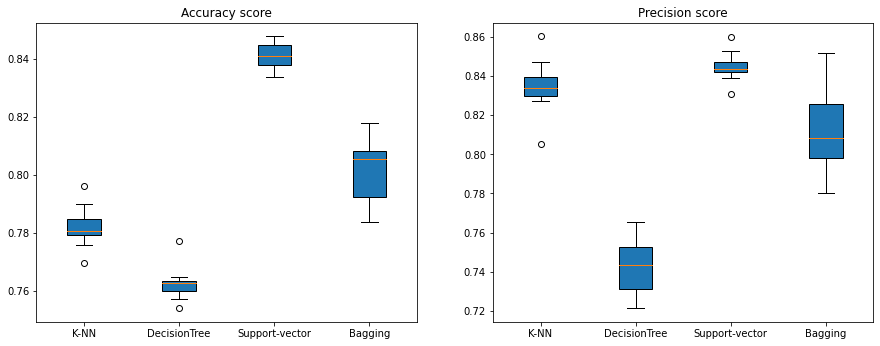

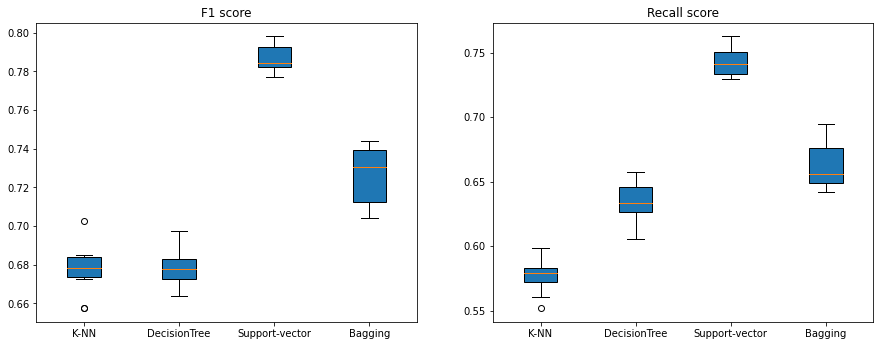

In [52]:
multiplot_generator(demo_plot_and_yield_classification(), 2)

### Clustering Algorithms

In [53]:
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [54]:
X_pca_hv = pca.fit_transform(adata_hv.obsm['X_pca'])
# For comparison.
X_pca_copy = pca.fit_transform(adata_copy.obsm['X_pca'])

In [55]:
X_tsne_hv = tsne.fit_transform(adata_hv.X)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 638 samples in 0.001s...
[t-SNE] Computed neighbors for 638 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 638 / 638
[t-SNE] Mean sigma: 6.840449
[t-SNE] KL divergence after 250 iterations with early exaggeration: 204.861435
[t-SNE] KL divergence after 1000 iterations: 5.632634


In [56]:
X_fa_hv = fa.fit_transform(adata_hv.X)

#### K-means

The Elbow Method is one of the most popular methods to determine this optimal value of k. The idea here is that when adding clusters, at some point, the gains in the metric will really slow down, resulting in an elbow-like curve. The best number of clusters is thus the highest number before going beyond the elbow.

In [57]:
# Quick examination of elbow method to find the optimal number of clusters.
def elbow_f(data):
    print('Elbow Method to determine the number of clusters to be formed:')
    elbow_M = KElbowVisualizer(KMeans(random_state=seed), k=(2,10))
    elbow_M.fit(data)
    elbow_M.show()

In [58]:
# Function to display the silhouette coefficient for each sample on a per-cluster basis, 
#                         visualizing which clusters are dense and which are not for k number of clusters.
def silhouette_f(n_clusters, data):
    model = KMeans(n_clusters=n_clusters, random_state=seed)

    sil_visualizer = SilhouetteVisualizer(model)
    sil_visualizer.fit(data)    
    sil_visualizer.show()

Elbow Method to determine the number of clusters to be formed:


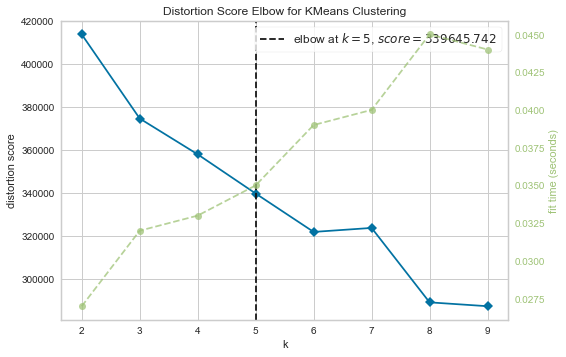

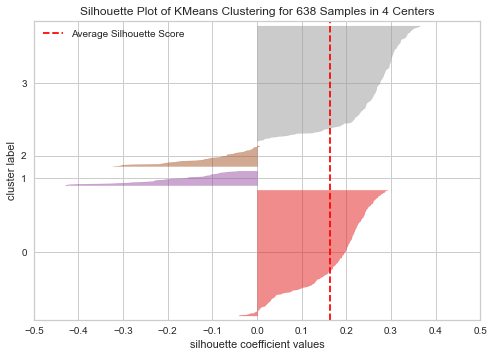

(None, None)

In [59]:
# Results with the data from adata_copy.
elbow_f(X_pca_hv), silhouette_f(4, X_pca_hv)

Elbow Method to determine the number of clusters to be formed:


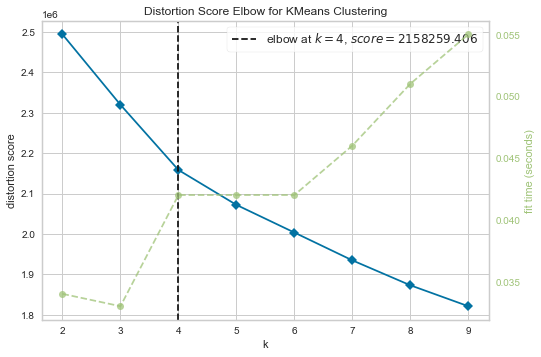

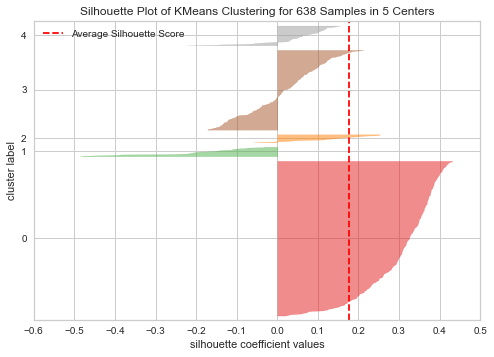

(None, None)

In [60]:
# Comparison to the data with the high variable genes.
elbow_f(X_pca_copy), silhouette_f(5, X_pca_copy)

### Models

In [61]:
# # Function to measure Dunn Index. (Implemented only in k-means)
# def dunn_index(num_clusters, predictions, centroids):
#     cluster_list = []
#     for n in range(num_clusters):
#         n = prediction.loc[prediction.Species == n]
#         cluster_list.append(n.values)
#     max_intracluster_dist = max(diameter(cluster_list[labels==i]) for i in np.unique(predictions))
#     if m = 
#     cluster_dmat = spatial.distance_matrix(centroids, centroids)
#     np.fill_diagonal(cluster_dmat, np.inf)
#     min_intercluster_dist = cluster_sizes.min()
#     return min_intercluster_dist / max_intracluster_dist

In [62]:
# Function to measure Purity.
def purity_score(true_labels, predictions):
    # To compute Purity it is necessary to create a confusion matrix.
    confusion_matrix = metrics.cluster.contingency_matrix(true_labels, predictions)
    return np.sum(np.amax(confusion_matrix, axis=0)) / np.sum(confusion_matrix) 
# For each cluster, select the maximum value from its row, 
#   sum them together and finally divide by the total number of data points.

In [63]:
# Create dictionaries to save the results.
keysList_clustering = ['k-means', 'HAs-l', 'HAm-l', 'Spectral']        
names_of_metrics_clustering = ['Silhouette_coefficients', 'Davies_bouldin', 'Purity', 'Rand_measure']        
create_dictionaries(names_of_metrics_clustering, keysList_clustering)

In [64]:
true_labels = np.array(cell_id).squeeze()
# Clustering.
def clustering_(data):
    for m in keysList_clustering:
        range_n_clusters = np.arange(2,12)
        for num_clusters in range_n_clusters:
            i = num_clusters - 2
        
            m_cluster = {'k-means': KMeans(n_clusters=num_clusters),
                          'HAs-l': AgglomerativeClustering(n_clusters=num_clusters, linkage='single'),
                          'HAm-l': AgglomerativeClustering(n_clusters=num_clusters, linkage='complete'),
                          'Spectral': SpectralClustering(n_clusters=num_clusters)}
       
            testing_model = m_cluster[m]
            clustering = testing_model.fit(data)
            cluster_labels = clustering.labels_
        
            Silhouette_coefficients[m][i] = (silhouette_score(data, cluster_labels,
                                                              metric='euclidean'))
            Davies_bouldin[m][i] = (davies_bouldin_score(data, cluster_labels))
            Purity[m][i] = (purity_score(true_labels, cluster_labels))
            Rand_measure[m][i] = (metrics.rand_score(true_labels, cluster_labels))

In [65]:
# Perform clustering.
clustering_(X_fa_hv)

### Visualization

In [66]:
clustering = ['K-Means', 'HAsingle-l', 'HAmax-l', 'Spectral']

In [67]:
def demo_plot_and_yield_clustering():
    yield
    plt.boxplot(Silhouette_coefficients.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(clustering) + 1), clustering)
    plt.title('Silhouette Coefficients')
    yield
    plt.boxplot(Davies_bouldin.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(clustering) + 1), clustering)
    plt.title('Davies-Bouldin score')
    yield
    plt.boxplot(Purity.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(clustering) + 1), clustering)
    plt.title('Purity score')
    yield
    plt.boxplot(Rand_measure.values(), patch_artist=True, widths=0.35)
    plt.xticks(range(1, len(clustering) + 1), clustering)
    plt.title('Rand measure')

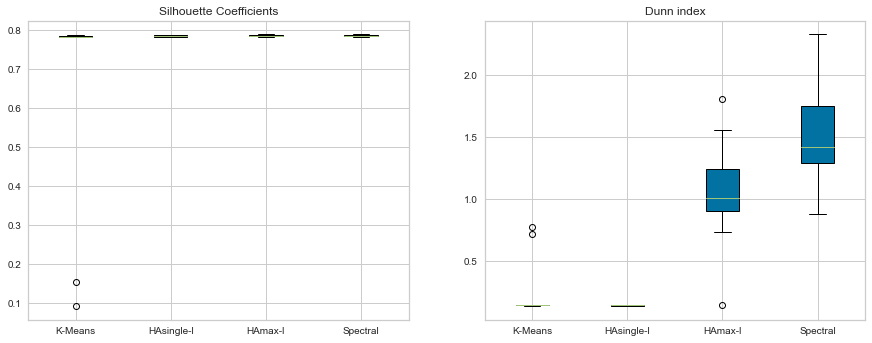

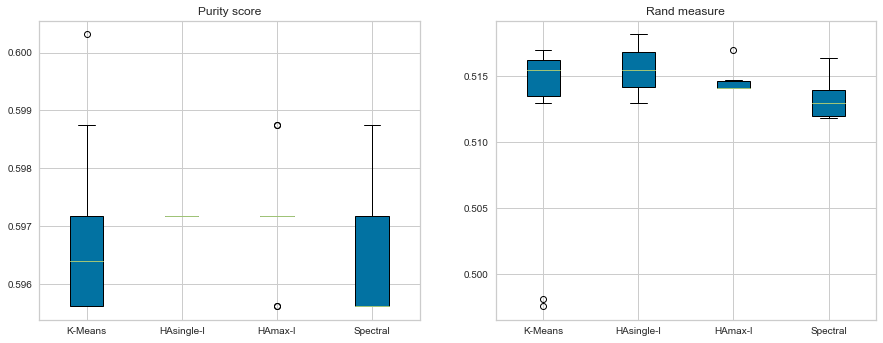

In [68]:
multiplot_generator(demo_plot_and_yield_clustering(), 2)